# Dataset exploration

This notebook explores the UCR and NAB datasets, including various statistics related to these datasets. 

Additionally, the notebook includes the processing of the NAB datasets to ensure that anomalies are present in both the training and testing splits.

In [2]:
import json
import os
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from latex_figures import set_size

# Latex font in plots
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",

    "axes.labelsize": 10,
    "font.size": 10,

    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

# plot style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update(tex_fonts)


## UCR

This section covers exploration and processing of UCR datasets.

In [3]:
# Load all UCR datasets
path = f'./data/datasets/'
files = [
    f
    for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f)) and f.endswith('.txt')
]

datasets = []
for f in files:
    ts = np.loadtxt(f'./data/datasets/{f}')
    test_start, anomaly_start, anomaly_end = f[:-4].split('_')[-3:]
    datasets.append(
        (
            f,
            len(ts),
            int(test_start),
            len(ts) - int(test_start),
            int(anomaly_end) - int(anomaly_start),
        )
    )

# Create a pandas DataFrame with various statistics
df = pd.DataFrame(
    datasets, columns=['Name', 'Length', 'Train', 'Test', 'Anomaly Length']
)
df.describe()

,Length,Train,Test,Anomaly Length
count,250.000000,250.000000,250.000000,250.000000
mean,77415.064000,21209.796000,56205.268000,196.452000
std,120321.279605,32481.890956,92284.442846,238.199571
min,6684.000000,1000.000000,3301.000000,0.000000
25%,11308.000000,4000.000000,7001.000000,48.000000
50%,30066.000000,9406.000000,25001.000000,100.000000
75%,80000.750000,23300.000000,47104.250000,267.500000
max,900000.000000,250000.000000,707630.000000,1700.000000


The UCR datasets are pre-divided into training and testing sets, with anomalies present only in the test set. This characteristic makes the datasets semisupervised.

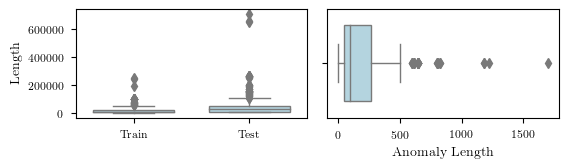

In [4]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))

df_melt = pd.melt(df, value_vars=['Train', 'Test'])
ax = sns.boxplot(
    data=df_melt,
    x='variable',
    y='value',
    ax=axs[0],
    linewidth=1,
    width=0.7,
    color='lightblue',
)
ax.set_ylabel('Length')
ax.set_xlabel('')

ax = sns.boxplot(
    data=df,
    x='Anomaly Length',
    ax=axs[1],
    linewidth=1,
    width=0.7,
    color='lightblue',
)
plt.tight_layout()

# fig.savefig('ucr_datasets_stats.pdf', format='pdf', bbox_inches='tight')

Some of the datasets are significantly longer than the others. Due to computational budget limitations, datasets containing more than 50 000 data points are excluded. As a result, 100 datasets are discarded, leaving a total of 150 datasets.

In [5]:
df_smaller = df[df['Length'] < 50000]
len(df_smaller)

150

Subsequently, selected datasets are visualized using the same statistics.

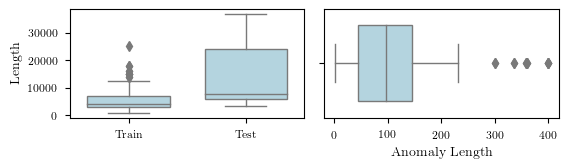

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))

df_melt = pd.melt(df_smaller, value_vars=['Train', 'Test'])
ax = sns.boxplot(
    data=df_melt,
    x='variable',
    y='value',
    ax=axs[0],
    linewidth=1,
    width=0.7,
    color='lightblue',
)
ax.set_ylabel('Length')
ax.set_xlabel('')

ax = sns.boxplot(
    data=df_smaller,
    x='Anomaly Length',
    ax=axs[1],
    linewidth=1,
    width=0.7,
    color='lightblue',
)
plt.tight_layout()

# fig.savefig('selected_datasets_stats.pdf', format='pdf', bbox_inches='tight')


For purposes of meta-learning, the remaining datasets are split into meta train and meta test datasets.

As the number of datasets is 150, we split so that there is 100 training datasets and 50 testing datasets.

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_smaller['Name'].values, test_size=0.333, random_state=42)

# Do not rewrite
# with open('./data/train.txt','w') as f:
#     for n in train:
#         f.write("%s\n" % n)

# with open('./data/test.txt','w') as f:
#     for n in test:
#         f.write("%s\n" % n)


## Numenta NAB datasets



In [7]:
# Load timestamps of single point anomalies
with open('./data/datasets/numenta/combined_labels.json', 'r') as f:
    labels = json.load(f)
labels = {k.split('/')[1]: v for k, v in labels.items()}

# Load timestamps of anomaly windows around the single point datasets
with open('./data/datasets/numenta/combined_windows.json', 'r') as f:
    window_labels = json.load(f)
window_labels = {k.split('/')[1]: v for k, v in window_labels.items()}

# Read paths of nab dataset files
path = 'data/datasets/numenta'
files = [
    f
    for f in os.listdir(path)
    if os.path.isfile(os.path.join(path, f)) and f.endswith('.csv')
]

datasets = []
for f in files:
    # Load dataset into DataFrame and create label column
    ts = pd.read_csv(f'./data/datasets/numenta/{f}')
    ts['label'] = 0

    # Split time series into train and test splits with 50/50 ratio
    train = ts.loc[: len(ts) / 2]
    test = ts.loc[len(ts) / 2 :]


    train_anmly_cnt, test_anmly_cnt = 0, 0

    # Label the train and test splits
    for tstamp, (s, e) in zip(labels[f], window_labels[f]):
        if tstamp in train['timestamp'].values:
            train_anmly_cnt += 1
            train.loc[
                (train['timestamp'] >= s) & (train['timestamp'] <= e), 'label'
            ] = 1
        else:
            test_anmly_cnt += 1
            test.loc[
                (test['timestamp'] >= s) & (test['timestamp'] <= e), 'label'
            ] = 1

    datasets.append(
        (
            f,
            len(ts),
            train_anmly_cnt,
            test_anmly_cnt,
            len(train[train['label'] == 1]),
            len(test[test['label'] == 1]),
            len(train[train['label'] == 1]) + len(test[test['label'] == 1]),
        )
    )

# Create a DataFrame from collected statstics
df = pd.DataFrame(
    datasets,
    columns=[
        'Name',
        'Length',
        'T A',
        'Te a',
        'Train Anomaly',
        'Test Anomaly',
        'Anomaly Length',
    ],
)
df.describe()


,Length,T A,Te a,Train Anomaly,Test Anomaly,Anomaly Length
count,25.00000,25.00000,25.000000,25.000000,25.000000,25.00000
mean,8462.76000,1.64000,1.320000,476.360000,347.600000,823.96000
std,6948.11477,0.81035,0.556776,433.887359,314.953436,675.79524
min,1127.00000,1.00000,1.000000,28.000000,50.000000,112.00000
25%,2500.00000,1.00000,1.000000,134.000000,94.000000,246.00000
50%,4032.00000,1.00000,1.000000,200.000000,264.000000,402.00000
75%,15853.00000,2.00000,2.000000,794.000000,396.000000,1580.00000
max,22695.00000,4.00000,3.000000,1264.000000,1132.000000,2264.00000


By using the NAB datasets, an effort for completely unsupervised learning setting is made by removing all datasets that do not containt anomaly in training or testing split.

In [ ]:
## No Need to rerun as all the files have been deleted
# files_to_delete = df[~((df[['T A', 'Te a']].sum(axis=1) >= 2) & (df['T A'] > 0) & (df['Te a'] > 0))]['Name'].values.tolist()
# for file in files_to_delete:
#     os.remove(f'data/datasets/numenta/{file}')
#     print(f"Deleted file: {file}")


The 10% contamination rate presented in NAB whitepaper can be seen across all datasets.

In [9]:
df.assign(
    **{
        'Contamination rate': lambda x: (x['Train Anomaly'] + x['Test Anomaly']) / x['Length'],
        'Contamination rate Train': lambda x: x['Train Anomaly'] / x['Length'],
        'Contamination rate Test': lambda x: x['Test Anomaly'] / x['Length'],
    }
)


,Name,Length,T A,Te a,Train Anomaly,Test Anomaly,Anomaly Length,Contamination rate,Contamination rate Train,Contamination rate Test
0,exchange-2_cpm_results.csv,1624,1,1,80,80,160,0.098522,0.049261,0.049261
1,exchange-3_cpc_results.csv,1538,2,1,100,50,150,0.097529,0.065020,0.032510
2,exchange-4_cpc_results.csv,1643,2,1,108,54,162,0.098600,0.065733,0.032867
3,exchange-4_cpm_results.csv,1643,2,2,80,80,160,0.097383,0.048691,0.048691
4,ec2_cpu_utilization_5f5533.csv,4032,1,1,200,200,400,0.099206,0.049603,0.049603
5,ec2_cpu_utilization_53ea38.csv,4032,1,1,200,200,400,0.099206,0.049603,0.049603
6,ec2_cpu_utilization_fe7f93.csv,4032,1,2,134,268,402,0.099702,0.033234,0.066468
7,ec2_disk_write_bytes_c0d644.csv,4032,1,2,134,268,402,0.099702,0.033234,0.066468
8,elb_request_count_8c0756.csv,4032,1,1,200,200,400,0.099206,0.049603,0.049603
9,grok_asg_anomaly.csv,4621,2,1,308,154,462,0.099978,0.066652,0.033326


Lastly, same statistics are plotted for NAB datasets.

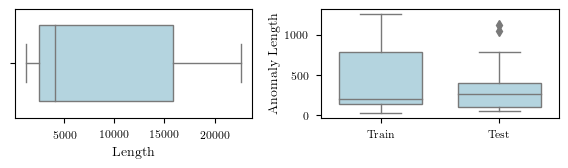

In [32]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))

df_melt = pd.melt(df, value_vars=['Train Anomaly', 'Test Anomaly'])
ax = sns.boxplot(
    data=df_melt,
    x='variable',
    y='value',
    ax=axs[1],
    linewidth=1,
    width=0.7,
    color='lightblue',
)
ax.set_ylabel('Anomaly Length')
ax.set_xlabel('')
ax.set_xticklabels(['Train', 'Test'])

ax = sns.boxplot(
    data=df, x='Length', ax=axs[0], linewidth=1, width=0.7, color='lightblue'
)
plt.tight_layout()

# fig.savefig('./images/numenta_stats.pdf', format='pdf', bbox_inches='tight')


NAB datasets are not split into meta train and meta test, as cross validation will used because of the considerably low number of datasets (25).